# O que é Data Augmentation e como isso ajuda?
**Data Augmentation** é uma técnica utilizada para expandir e diversificar um conjunto de dados, aplicando diferentes transformações às imagens existentes. Para ilustrar, alguns exemplos comuns incluem zoom, inversão horizontal ou vertical, deslocamento do centro da imagem, e por aí vai.
É um fato bem conhecido que **Redes Neurais Profundas** funcionam melhor quando treinadas com conjuntos de dados grandes e diversificados.

Este notebook abordará a **Data Augmentation em imagens**.  
Nosso foco será em **diferentes técnicas** para realizar **Data Augmentation**.

Utilizaremos **TensorFlow** e **Keras** para implementar essas técnicas, o que nos ajudará a compreender melhor esse conceito.


In [ ]:
!pip install tensorflow

import random
from shutil import copyfile
import datetime
import numpy as np

import os,sys
import zipfile
import shutil
from os import path, getcwd, chdir
from pathlib import Path
from shutil import copyfile
from typing import Union


## Bare minimum library requirement
import tensorflow as tf
import keras
#Keras provide API for Augmentation helps in generation
from tensorflow.keras.optimizers import RMSprop

from glob import glob
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread, imshow, subplots, show

In [ ]:
gpu_details = tf.config.experimental.list_physical_devices('GPU')
if gpu_details:
    for gpu in gpu_details:
        print(f"Device: {gpu}")
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU found.")


Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


Imagine a situação em que precisamos classificar uma imagem como **gato** ou **cachorro**. Nosso conjunto de dados contém diversas imagens desses animais.

Para otimizar o treinamento do modelo, é essencial manipular essas imagens em tempo real. Uma abordagem eficiente é aplicar **data augmentation**, gerando lotes de tensores modificados dinamicamente.

Utilizar **Keras** para essa tarefa traz uma vantagem adicional: as transformações são aplicadas apenas durante o treinamento, preservando os dados originais intactos. Isso permite aumentar a diversidade do conjunto de treino sem alterar os arquivos fonte.

Antes de tudo, vamos baixar e extrair nosso Dataset.

In [ ]:
# Nome do arquivo e pasta de destino
zip_path = "catsdogs.zip"
extract_path = "cats_and_dogs"

# Baixa e extrai apenas se ainda não existir
# Caso um dia o link de download quebrar, baixe manualmente da internet (busque por Microsoft Cats and Dogs. Atualmente, tem no Kaggle)
if not os.path.exists(extract_path):
    !wget -O {zip_path} https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
    !unzip -q {zip_path} -d {extract_path}
    !rm {zip_path}
    print("Download e extração concluídos.")
else:
    print("Dataset já está disponível.")


--2025-05-06 23:05:59--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.25.248.114, 2600:1413:a000:138c::317f, 2600:1413:a000:1383::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.25.248.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘catsdogs.zip’

catsdogs.zip        100%[===================>] 786.67M   165MB/s    in 6.7s    

2025-05-06 23:06:06 (117 MB/s) - ‘catsdogs.zip’ saved [824887076/824887076]

Download e extração concluídos.


Agora, vamos dividir o dataset em treino e validação.

In [ ]:
def split_data(source: Union[str, Path], training: Union[str, Path], testing: Union[str, Path], split_size: float):
    source = Path(source)
    training = Path(training)
    testing = Path(testing)

    # Garante que os diretórios existem
    training.mkdir(parents=True, exist_ok=True)
    testing.mkdir(parents=True, exist_ok=True)

    # Filtra arquivos válidos
    valid_files = [f for f in source.iterdir() if f.is_file() and f.stat().st_size > 0]
    ignored_files = [f.name for f in source.iterdir() if f.is_file() and f.stat().st_size == 0]

    if ignored_files:
        print(f"Ignorando {len(ignored_files)} arquivos corrompidos: {ignored_files[:3]}{'...' if len(ignored_files) > 3 else ''}")

    # Embaralha e divide
    random.shuffle(valid_files)
    split_index = int(len(valid_files) * split_size)
    training_files = valid_files[:split_index]
    testing_files = valid_files[split_index:]

    # Copia arquivos
    for f in training_files:
        copyfile(f, training / f.name)
    for f in testing_files:
        copyfile(f, testing / f.name)

    !rm -rf {source}

    print(f"{len(training_files)} arquivos para treino, {len(testing_files)} para validação.")


In [ ]:
CAT_SOURCE_DIR = "cats_and_dogs/PetImages/Cat"
DOG_SOURCE_DIR = "cats_and_dogs/PetImages/Dog"

TRAINING_CATS_DIR = "catsvsdogs/train/Cat"
TESTING_CATS_DIR = "catsvsdogs/val/Cat"

TRAINING_DOGS_DIR = "catsvsdogs/train/Dog"
TESTING_DOGS_DIR = "catsvsdogs/val/Dog"

if not os.path.exists(TRAINING_CATS_DIR) or not os.listdir(TRAINING_CATS_DIR):
    split_size = 0.9
    split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
    split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)
    !rm -rf {extract_path}
    print("Dataset dividido em treino e validação.")
else:
    print("Dataset já foi dividido em treino e validação.")

Ignorando 1 arquivos corrompidos: ['666.jpg']
11250 arquivos para treino, 1250 para validação.
Ignorando 1 arquivos corrompidos: ['11702.jpg']
11250 arquivos para treino, 1250 para validação.
Dataset dividido em treino e validação.


Agora vamos conhecer um pouco sobre o conteúdo do nosso dataset.

In [ ]:
print("Total de imagens de gato: ",len(os.listdir(TRAINING_CATS_DIR)))
print("Total de imagens de gato: ",len(os.listdir(TRAINING_CATS_DIR)))
print("Total de imagens de cachorro: ",len(os.listdir(TRAINING_DOGS_DIR)))
print("Total de imagens de gato para validação: ",len(os.listdir(TESTING_CATS_DIR)))
print("Total de imagens de cachorro para validação: ",len(os.listdir(TESTING_DOGS_DIR)))

# Dimensões das imagens
shapes = []
for img_path in glob(os.path.join(TRAINING_CATS_DIR, "*.jpg"))[:4] + glob(os.path.join(TRAINING_DOGS_DIR, "*.jpg"))[:4]:
    img = Image.open(img_path)
    shapes.append(img.size)

print(f"Dimensões das primeiras 8 imagens:", shapes)

Total de imagens de gato:  11250
Total de imagens de gato:  11250
Total de imagens de cachorro:  11250
Total de imagens de gato para validação:  1250
Total de imagens de cachorro para validação:  1250
Dimensões das primeiras 8 imagens: [(320, 473), (107, 103), (500, 458), (500, 416), (375, 500), (500, 375), (494, 500), (500, 453)]


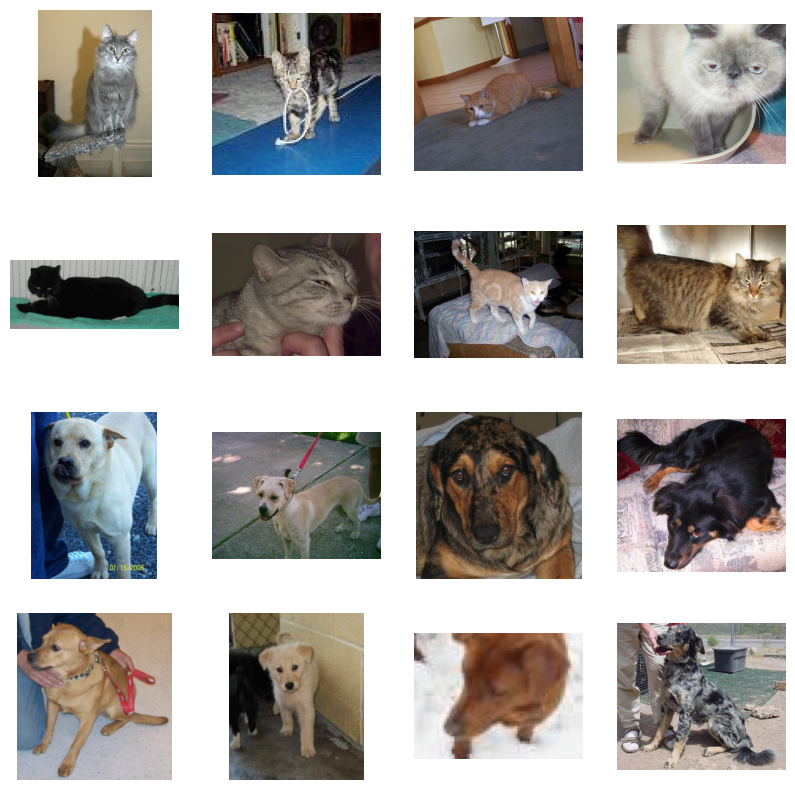

In [ ]:
%matplotlib inline

# Listar imagens de gatos e cachorros
cat_images = glob(os.path.join(TRAINING_CATS_DIR, "*.jpg"))[:8]
dog_images = glob(os.path.join(TRAINING_DOGS_DIR, "*.jpg"))[:8]

# Parâmetros para plotar o gráfico em 4x4 imagens
nrows = 4
ncols = 4

# Criar grid de imagens
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
images = cat_images + dog_images

for i, ax in enumerate(axes.flat):
    img = Image.open(images[i])
    ax.imshow(img)
    ax.axis("off")

plt.show()

## ImageDataGenerator

Diversas bibliotecas e APIs realizam data augmentation, gerando novas imagens conforme o usuário determina. A que será utilizada aqui é do Tensorflow, chamada ImageDataGenerator. No código abaixo, o processo começa ajustando o gerador aos dados com `fit()`, em seguida, cria um iterador de imagens transformadas com `flow()`. As imagens geradas são exibidas em uma grade 1x4 utilizando o Matplotlib. Cada imagem é mostrada após uma transformação aleatória, por exemplo rotação ou deslocamento (e muitas outras opções), permitindo visualizar a variedade que as transformações podem trazer para o modelo de deep learning.

In [ ]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def plot(data_generator, images):
    """
    Plota 4 imagens geradas por um objeto da classe ImageDataGenerator.
    """
    data_generator.fit(images)
    image_iterator = data_generator.flow(images)

    #Plot the images given by the iterator
    fig, rows = subplots(nrows=1, ncols=4, figsize=(18, 18))
    for row in rows:
        row.imshow(image_iterator.__next__()[0].astype('int'))
        row.axis('on')
    show()

Vamos fazer uma augmentation básica e, posteriormente, aplicaremos várias permutações e combinações dessas técnicas. **Vamos começar com a rotação da imagem por alguns graus para que as características (valores de pixels com base no arranjo espacial) sejam afetadas e o rótulo permaneça inalterado.**

In [ ]:
def imageAugmentor(images):
    data_generator = ImageDataGenerator(rotation_range=180) # Rotação aleatória entre -180 e 180 graus
    print("Rotação aleatória entre -180 e 180 graus")
    plot(data_generator, images)

    data_generator = ImageDataGenerator(width_shift_range=0.65) # Deslocamento horizontal aleatório de 0 a 65% da largura da imagem
    print(f"Deslocamento horizontal aleatório de 0 a 65% da largura da imagem")
    plot(data_generator, images)

    data_generator = ImageDataGenerator(vertical_flip=True, # flip vertical aleatório
                                        zoom_range=[0.2, 0.9], # zoom aleatório
                                        width_shift_range=0.2) # deslocamento horizontal aleatório
    print("Flip vertical aleatório, zoom aleatório, deslocamento horizontal aleatório")
    plot(data_generator, images)

    data_generator = ImageDataGenerator(horizontal_flip=True, # flip horizontal aleatório
                                        zoom_range=[1, 1.5], # zoom aleatório
                                        width_shift_range=0.2) # deslocamento horizontal aleatório
    print("Flip horizontal aleatório, zoom aleatório, deslocamento horizontal aleatório")
    plot(data_generator, images)

    data_generator = ImageDataGenerator(width_shift_range=[0.1, 0.5]) # deslocamento horizontal aleatório
    print("Deslocamento horizontal aleatório")
    plot(data_generator, images)

    data_generator = ImageDataGenerator(zoom_range=[1, 2], rotation_range=260) # zoom e rotação aleatórios
    print("Zoom e rotação aleatórios")
    plot(data_generator, images)

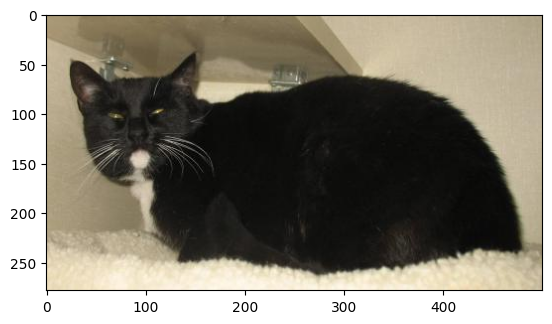

In [ ]:
# Escolhe gato aleatório
next_pic = random.sample(glob(os.path.join(TRAINING_CATS_DIR, "*.jpg")), 1)
image = plt.imread(next_pic[0])
# Cria dataset com apenas a imagem escolhida
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
imshow(images[0])
show()

**Alguns exemplos de como a augmentation de imagem ficou antes de ir para o modelo para treinamento.**

Rotação aleatória entre -180 e 180 graus


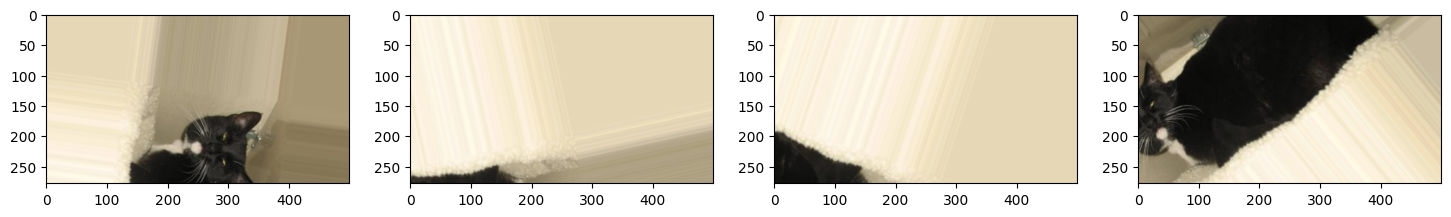

Deslocamento horizontal aleatório de 0 a 65% da largura da imagem


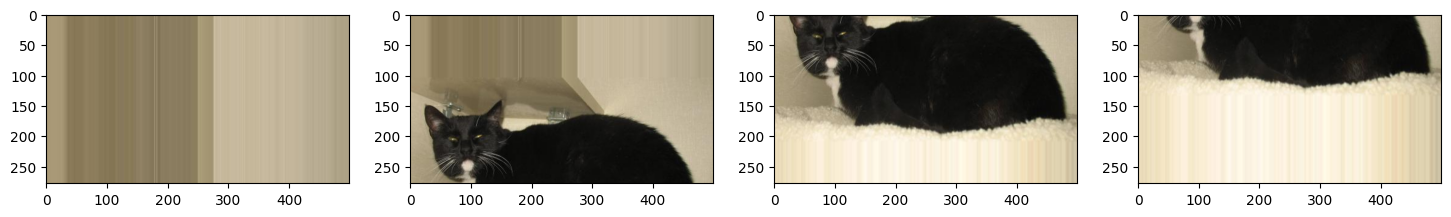

Flip vertical aleatório, zoom aleatório, deslocamento horizontal aleatório


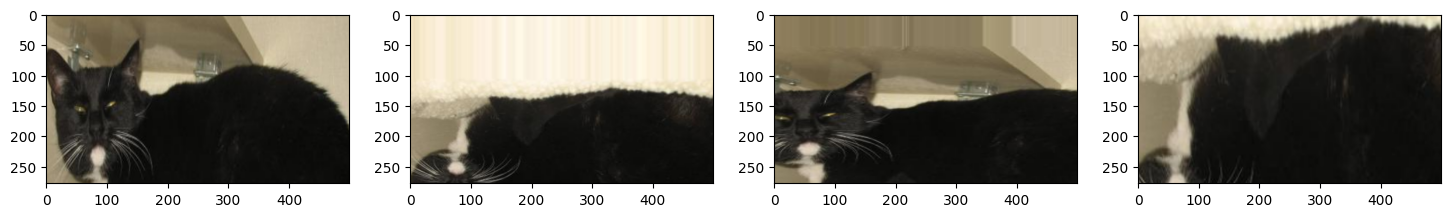

Flip horizontal aleatório, zoom aleatório, deslocamento horizontal aleatório


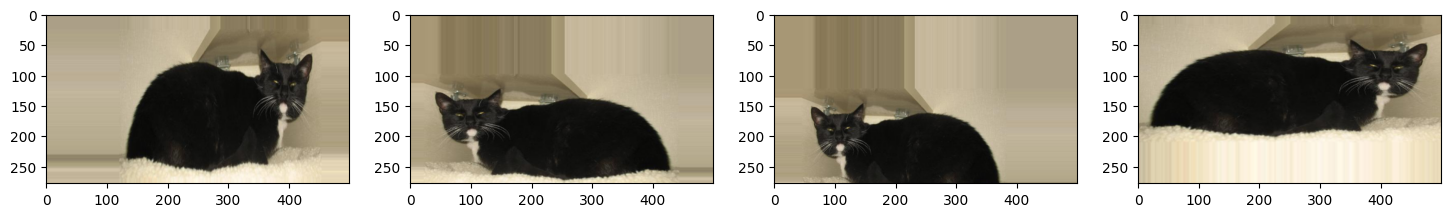

Deslocamento horizontal aleatório


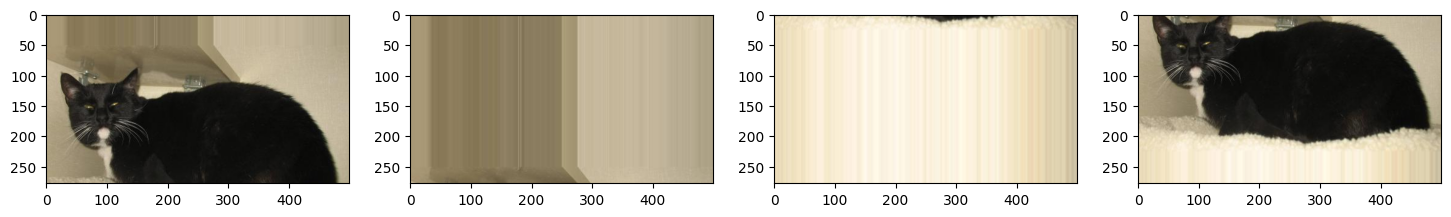

Zoom e rotação aleatórios


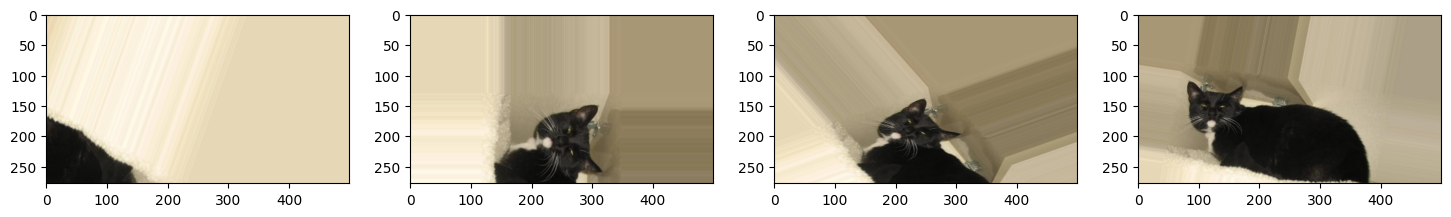

In [ ]:
imageAugmentor(images)

---


## ❓ Reflexão

Você consegue explicar, com suas palavras, o que ocorre no código acima de seleção de uma única imagem? Compreender o conceito por trás desse trecho de código ajudará na compreensão de passar imagens como inputs para redes neurais, especialmente o uso de `reshape`.

Para a resposta da pergunta acima e para futuros trabalhos, recomenda-se estudar as seguintes funções de bibliotecas:
- Reshape: https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
- Ler imagem e converter em um vetor numpy (Matplotlib): https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imread.html
- Leitura de imagens com TensorFlow: Aqui, utilizamos as funções da API de entrada e saída do TensorFlow, ou seja, as funções do módulo tf.io. Em particular, é interessante explorar o tf.io.read_file, que realiza a leitura da imagem e a armazena em um tensor do tipo string. Em seguida, a função tf.io.decode_jpeg (ou suas variantes para outros formatos como PNG) converte a imagem, armazenada como uma string, em um tensor com dimensões altura x largura x canais, contendo valores inteiros sem sinal de 8 bits. Este estudo é essencial para nos familiarizarmos com o framework, que será amplamente utilizado na etapa de aprendizado profundo.https://www.tensorflow.org/api_docs/python/tf/io. O tensorflow também permite converter imagens em vetores numPy, bastando apenas dar um image.numpy().

- Deixe sua resposta aqui!

😰 Atividade extra: O objetivo dessa atividade, **após o estudo da API do Tensorflow**, é realizar a leitura de imagens de gatos e cachorros, decodificá-las em escala de cinza (grayscale), e em seguida, convertê-las para o formato RGB. Para isso, algumas funções de criação de datasets como tf.data.Dataset.from_tensor_slices() (cria o dataset através de vetores passados) e dataset.map() (aplica uma função qualquer a todos os elementos do dataset) são de extrema importância, além, claro, das funções de processamento de imagem como tf.io.decode_jpeg() e tf.image.rgb_to_grayscale().

In [ ]:
# Deixe seu código de leitura das imagens usando Tensorflow aqui

---

## 🏹 Atividades - Vamos brincar de Data Augmentation
1. Use a classe ImageDataGenerator do TensorFlow para aplicar as seguintes transformações em um conjunto de 3 imagens aleatoriamente escolhidas:

  - **Rotação:** Aplique uma rotação aleatória entre -90 e 90 graus.
  - **Flip Horizontal:** Realize um flip horizontal aleatório nas imagens.
  - **Zoom:** Aplique um zoom aleatório variando entre 50% e 150%.
  - Teste e visualize as transformações usando o método plot().

2. Adicionar ruído (aleatório) a 1 imagem como parte do processo de data augmentation. DICA: usar `preprocessing_function` para colocar uma função

  - Crie uma função para adicionar ruído nas imagens. DICA: lembre-se das escalas das cores aqui, se for RGB, cada pixel não pode ter valores negativos ou maiores que 255 (ou 1.0, se estiver normalizado)
  - Configure o ImageDataGenerator e aplique a função de ruído nas imagens geradas.

3. Aplicar alterações de brilho e alterações no canal RGB usando o ImageDataGenerator.
  - Por exemplo, supomos que em uma determinada situação, temos pouquíssimas fotos de gatos e cães de uma determinada cor. Gostaríamos de gerar ainda mais imagens dos mesmos animais alterando os valores originais na escala RGB, ou, até mesmo, mudando o brilho dessas imagens.
  - O ImageDataGenerator possui os parâmetros necessários para realizar isso, pesquise-os.
  - Não esperamos um gabarito aqui, apenas brinque com as diferentes modificações que você pode realizar

In [ ]:
# Atividade 1

In [ ]:
# Atividade 2

In [ ]:
# Atividade 3

---

# Realização de Data Augmentation antes do treinamento

A partir deste ponto, o treinamento das redes neurais será iniciado, embora não seja o foco deste notebook. No entanto, caso deseje ajustar a Data Augmentation para treinar os modelos descritos abaixo, fique à vontade!

In [ ]:
# Diretório das imagens de treino
training_data_path = "catsvsdogs/train/"

Vamos declarar nossa rede neural usando o **keras**. O obejtivo desse notebook não é explicar redes neurais, então, por enquanto, você pode considerá-la uma caixa preta. Posteriormente, uma aula inteira será dedicada para isso.

In [ ]:
class NeuralNet:
    '''
    Responsável pelo esqueleto da rede neural
    '''
    '''
    Design sequencial de camadas para interconectar várias camadas.
    Visão geral seria
     ___________________________________________________
    |conv-->pool-->conv-->pool-->flatten-->dense-->dense|
     ---------------------------------------------------
    '''

    def neuralModeling(self, learning_rate):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (3, 3),
                                   activation='relu',
                                   input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        #Model compilation
        model.compile(
            optimizer=RMSprop(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        #model summary
        model.summary()

        return model

    '''
    Constructor of the class
    '''

    def __init__(self):
        print("Object getting created")

In [ ]:
# Augmentation datagen
datagen = ImageDataGenerator(
    rescale=1./255, # normaliza os valores dos pixels para estarem entre 0 e 1
    rotation_range=60,  # rotaciona aleatoriamente as imagens no intervalo (graus, 0 a 180)
    width_shift_range=0.1,  # desloca aleatoriamente as imagens horizontalmente (fração da largura total)
    height_shift_range=0.1,  # desloca aleatoriamente as imagens verticalmente (fração da altura total)
    zoom_range=[0.9, 1.1],  # aplica zoom aleatório na imagem
    horizontal_flip=True,  # inverte as imagens horizontalmente de forma aleatória
    vertical_flip=True)  # inverte as imagens verticalmente de forma aleatória

# Gerador de imagens com augmentation
generator = datagen.flow_from_directory(
    training_data_path,
    target_size=(150, 150),
    batch_size=100,
    class_mode='binary')

Found 22498 images belonging to 2 classes.


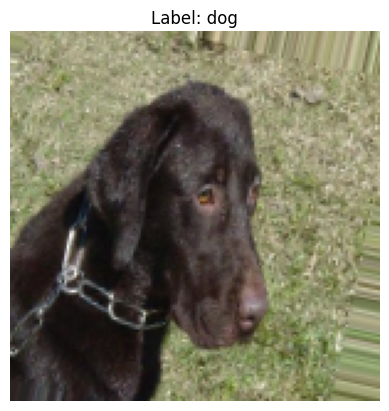

In [ ]:
# Obtém um lote de imagens e rótulos do gerador
images, labels = next(generator)  # Recupera um lote

# Converte rótulos para formato legível por humanos
labels = ['dog' if label == 1 else 'cat' for label in labels]

# Seleciona uma imagem aleatória do lote
idx = np.random.randint(len(images))
image = images[idx]

# Mostra a imagem
plt.imshow(image)
plt.axis('off')  # Esconde os eixos
plt.title(f"Label: {labels[idx]}")
plt.show()

# Treinamento do Modelo
**Vamos fazer o treinamento de modelos para diferenciar gatos de cães.**  
Vamos fazer um modelo **sem Data Augmentation** e outro **com Data Augmentation** para comparar os resultados.  
Muito provavelmente esse é seu primeiro contato com um treinamento de classificação de imagens. Como esse não é o foco desse notebook, essa seção não possui atividades, mas ela é bem importante ver o impacto da Data Augmentation, para nos familiarizarmos com algumas ferramentas de treinamento (nesse caso o Tensorflow) e para "dar play" no treinamento do seu primeiro modelo de classificação de imagens. Esse tipo de código, com algumas poucas otimizações, é o tipo de código que usamos, por exemplo, em competições no Kaggle.  
As 2 etapas de treinamento podem demorar alguns minutos, talvez até 2h dependendo das suas configurações de máquina. Se estiver no Google Colab, recomendados que altere o runtime para a melhor placa de vídeo disponível. Apesar do tempo de espera, rodar todas as células é muito importante para ver seu modelo aprendendo pela primeira vez.

In [ ]:
# Dados de treino e validação
training_data_path = "catsvsdogs/train/"
validation_data_path = "catsvsdogs/val/"

# Parâmetros de treino
epochs = 100
batch_size=100
learning_rate = 0.001

In [ ]:
# Cria modelo
net = NeuralNet()

# Vamos treinar 2 modelos idênticos, um com data augmentation e outro sem
model_no_aug = net.neuralModeling(learning_rate)
model_aug = net.neuralModeling(learning_rate)

# Vamos parar o treinamento se a perda não diminuir após 3 épocas
callback = keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

Object getting created


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,393 (388.25 KB)

 Trainable params: 99,393 (388.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 34, 34, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,393 (388.25 KB)

 Trainable params: 99,393 (388.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Datagen do conjunto de treino sem augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

# Gerador do conjunto de treino sem augmentation
train_generator = train_datagen.flow_from_directory(
    training_data_path,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

# Datagen da validação
validation_datagen = ImageDataGenerator(rescale=1./255)

# validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_data_path,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

# Datagen do conjunto de treino com augmentation
train_aug_datagen = ImageDataGenerator(
    rescale=1./255, # normaliza os valores dos pixels para estarem entre 0 e 1
    rotation_range=60,  # rotaciona aleatoriamente as imagens no intervalo (graus, 0 a 180)
    width_shift_range=0.1,  # desloca aleatoriamente as imagens horizontalmente (fração da largura total)
    height_shift_range=0.1,  # desloca aleatoriamente as imagens verticalmente (fração da altura total)
    zoom_range=[0.9, 1.1],  # aplica zoom aleatório na imagem
    horizontal_flip=True,  # inverte as imagens horizontalmente de forma aleatória
    vertical_flip=True)  # inverte as imagens verticalmente de forma aleatória

# Gerador do conjunto de treino com augmentation
train_aug_generator = train_aug_datagen.flow_from_directory(
    training_data_path,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 22498 images belonging to 2 classes.


In [ ]:
history_no_aug = model_no_aug.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [callback]
                    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
121/225 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.5420 - loss: 0.6906

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 59s 236ms/step - accuracy: 0.5611 - loss: 0.6817 - val_accuracy: 0.7152 - val_loss: 0.5766
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - accuracy: 0.6955 - loss: 0.5790 - val_accuracy: 0.7288 - val_loss: 0.5462
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 191ms/step - accuracy: 0.7444 - loss: 0.5104 - val_accuracy: 0.7404 - val_loss: 0.5324
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.7858 - loss: 0.4619 - val_accuracy: 0.8020 - val_loss: 0.4216
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - accuracy: 0.8082 - loss: 0.4160 - val_accuracy: 0.8164 - val_loss: 0.3949
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.8242 - loss: 0.3856 - val_accuracy: 0.8244 - val_loss: 0.3813
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.8416 - loss: 0.3473 - val_accuracy: 0.8160 - val_loss: 0.3803
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.8576 - loss: 0.322

In [ ]:
history_aug = model_aug.fit(train_aug_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [callback]
                    )

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 153s 663ms/step - accuracy: 0.5270 - loss: 0.6897 - val_accuracy: 0.5956 - val_loss: 0.6583
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 148s 659ms/step - accuracy: 0.6216 - loss: 0.6485 - val_accuracy: 0.6908 - val_loss: 0.5888
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 147s 653ms/step - accuracy: 0.6731 - loss: 0.6074 - val_accuracy: 0.7104 - val_loss: 0.5622
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 146s 650ms/step - accuracy: 0.6965 - loss: 0.5833 - val_accuracy: 0.7232 - val_loss: 0.5542
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 148s 657ms/step - accuracy: 0.7101 - loss: 0.5616 - val_accuracy: 0.6456 - val_loss: 0.7808
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 149s 661ms/step - accuracy: 0.7173 - loss: 0.5543 - val_accuracy: 0.7304 - val_loss: 0.5455
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 149s 660ms/step - accuracy: 0.7269 - loss: 0.5456 - val_accuracy: 0.7600 - val_loss: 0.4898
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 149s 663ms/step - accuracy: 

## Resultados

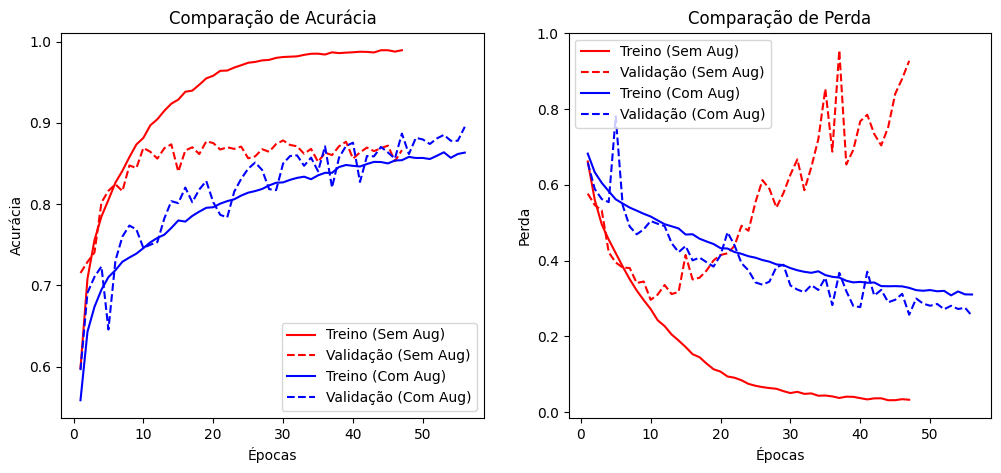

In [ ]:
def plot_training_comparison(history_no_aug, history_aug):
    # Extrair métricas dos históricos
    acc_no_aug = history_no_aug.history['accuracy']
    val_acc_no_aug = history_no_aug.history['val_accuracy']
    loss_no_aug = history_no_aug.history['loss']
    val_loss_no_aug = history_no_aug.history['val_loss']

    acc_aug = history_aug.history['accuracy']
    val_acc_aug = history_aug.history['val_accuracy']
    loss_aug = history_aug.history['loss']
    val_loss_aug = history_aug.history['val_loss']

    epochs_no_aug = range(1, len(acc_no_aug) + 1)
    epochs_aug = range(1, len(acc_aug) + 1)


    # Criar gráficos
    plt.figure(figsize=(12, 5))

    # Comparação de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_no_aug, acc_no_aug, 'r-', label='Treino (Sem Aug)')
    plt.plot(epochs_no_aug, val_acc_no_aug, 'r--', label='Validação (Sem Aug)')
    plt.plot(epochs_aug, acc_aug, 'b-', label='Treino (Com Aug)')
    plt.plot(epochs_aug, val_acc_aug, 'b--', label='Validação (Com Aug)')
    plt.title('Comparação de Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Comparação de Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs_no_aug, loss_no_aug, 'r-', label='Treino (Sem Aug)')
    plt.plot(epochs_no_aug, val_loss_no_aug, 'r--', label='Validação (Sem Aug)')
    plt.plot(epochs_aug, loss_aug, 'b-', label='Treino (Com Aug)')
    plt.plot(epochs_aug, val_loss_aug, 'b--', label='Validação (Com Aug)')
    plt.title('Comparação de Perda')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

# Chamada da função
plot_training_comparison(history_no_aug, history_aug)

***Sem augmentation geramos um modelo overfittado, pois a acurácia de treino chega a quase 100% enquanto na validação cai para 85%. Já com augmentation geramos um modelo mais robusto, com aurácia de treino que ainda segue a validação, e ainda tem uma loss muito menor. Esse modelo tem bastante potencial para aumentar a sua acurácia de treino e validação, enquanto o sem augmentation tem pouca coisa para aprender com esses dados repetidos.***

